# Section 1 - Libraries

In [1]:
## Libraries

import pandas as pd
import numpy as np
import io
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpStatus
import time 
import seaborn as sns
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed


# Section 2 - Read Data

In [97]:
# read input data
INPUT_PATH = 'D:/MpEnsystems/SE4ALL DF 2024 - 2025/DF model/input files for model/input data/'

OUTPUT_PATH = 'D:/MpEnsystems/SE4ALL DF 2024 - 2025/DF model/input files for model/output/'



ppa =pd.read_excel(INPUT_PATH + 'Generation_stack.xlsx') # PPA data of thermal plants (Capacity, ramping limts, technical min, variable cost)
projected_demand = pd.read_csv(INPUT_PATH + 'demand.csv') # Discom hourly demand in MW 
market_price = pd.read_excel(INPUT_PATH+'market_rate.xlsx') # Power market RTM prices for last year
re = pd.read_excel(INPUT_PATH +'RE.xlsx') 
tariff = pd.read_csv(INPUT_PATH +'tariff.csv') # cluster wise hourly tariff


# Section 3 - Trigger calculation for DR and DF


Creates triggers for each cluster based on slotwise per unit generation cost
For DR - triggers are generated for slots with pu generation cost is more than the threshold value
For DF - triggers are generated for slots with pu generation cost higher than upper limit or lower than lower limit
Triggers are created in a way to shift the demand from slots with higher pu generation cost to slots with lower generation cost

In [8]:
def trigger_calculation2(pu_gen_cost, tariff, mode, n):
    
    # pricing signal calculation based on monthly variation in slot wise per unit generation cost (Actual difference)
    
    pu_gen_cost_daily = pd.DataFrame(columns=range(365), index=range(24))
    monthly_avg = pd.DataFrame(columns=range(12), index=range(24))

    for d in range(len(pu_gen_cost_daily.columns)):
        pu_gen_cost_daily.iloc[:, d] = pu_gen_cost[d*24:(d+1)*24]

    for m in range(len(monthly_avg.columns)):
        monthly_avg.iloc[:, m] = pu_gen_cost_daily.iloc[:, m*30:(m+1)*30].mean(axis=1)

    triggers = pd.DataFrame(index=range(len(pu_gen_cost)), columns=tariff.columns)
    DF_trigger = pd.DataFrame(index=range(len(pu_gen_cost)), columns=['trigger(INR/kWH)', 'month'])
    DR_incentive = pd.DataFrame(index=range(len(pu_gen_cost)), columns=['trigger(INR/kWH)', 'month'])

    for m in range(len(monthly_avg.columns)):
        DF_trigger.iloc[m*30*24:30*24*(m+1), 1] = m
        DR_incentive.iloc[m*30*24:30*24*(m+1), 1] = m    

    DF_trigger.iloc[12*30*24:, 1] = 11
    DR_incentive.iloc[12*30*24:, 1] = 11

    DR_lambda = 0.3
    DF_lambda = 0.3
    
    DF_m = pd.DataFrame(np.zeros((24, 12)), columns=range(12))
    DR_m = pd.DataFrame(np.zeros((24, 12)), columns=range(12))
    
    for m in range(12):
        gencdc = monthly_avg.iloc[:, m].sort_values().reset_index()
        monthly_gen_avg = gencdc.iloc[:, 1]
        mean_cost_ub = monthly_gen_avg[20]
        mean_cost_lb = monthly_gen_avg[3]
        threshold = monthly_gen_avg[20]

        for s in range(24):
            if monthly_avg.iloc[s, m] > mean_cost_ub:
                DF_m.iloc[s, m] = -mean_cost_ub + monthly_avg.iloc[s, m]
            elif monthly_avg.iloc[s, m] < mean_cost_lb:
                DF_m.iloc[s, m] = -mean_cost_lb + monthly_avg.iloc[s, m]
            if monthly_avg.iloc[s, m] >= threshold:
                DR_m.iloc[s, m] = -threshold + monthly_avg.iloc[s, m]

    for d in range(365):
        try:
            month_index = int(DF_trigger.iloc[d*24, 1])
            DF_trigger.iloc[d*24:(d+1)*24, 0] = DF_m.iloc[:, month_index]
            DR_incentive.iloc[d*24:(d+1)*24, 0] = DR_m.iloc[:, month_index]
        except Exception as e:
            logging.error(f"Error processing day {d}: {e}")

    for i in range(len(tariff.columns)):
        if mode[i] == 'DR':
            triggers.iloc[:, i] = DR_incentive.iloc[:, 0] * (DR_lambda + n*0.1) + tariff.iloc[:, i]
        elif mode[i] == 'DF':
            triggers.iloc[:, i] = tariff.iloc[:, i] + DF_trigger.iloc[:, 0] * (DF_lambda + n*0.1)
        else:
            triggers.iloc[:, i] = DR_incentive.iloc[:, 0] * (1 + n*0.1)

    return triggers



In [30]:
def trigger_calculation4(pu_gen_cost, tariff, mode, n):
    
    # pricing signal calculation based on monthly variation in slot wise per unit generation cost levels (Step function)
    number_of_trigger_levels = 5
    pu_gen_cost_daily = pd.DataFrame(columns=range(365), index=range(24))
    monthly_avg = pd.DataFrame(columns=range(12), index=range(24))

    for d in range(len(pu_gen_cost_daily.columns)):
        pu_gen_cost_daily.iloc[:, d] = pu_gen_cost[d*24:(d+1)*24]

    for m in range(len(monthly_avg.columns)):
        monthly_avg.iloc[:, m] = pu_gen_cost_daily.iloc[:, m*30:(m+1)*30].mean(axis=1)

    triggers = pd.DataFrame(index=range(len(pu_gen_cost)), columns=tariff.columns)
    DF_trigger = pd.DataFrame(index=range(len(pu_gen_cost)), columns=['trigger(INR/kWH)', 'month'])
    DR_incentive = pd.DataFrame(index=range(len(pu_gen_cost)), columns=['trigger(INR/kWH)', 'month'])

    for m in range(len(monthly_avg.columns)):
        DF_trigger.iloc[m*30*24:30*24*(m+1), 1] = m
        DR_incentive.iloc[m*30*24:30*24*(m+1), 1] = m    

    DF_trigger.iloc[12*30*24:, 1] = 11
    DR_incentive.iloc[12*30*24:, 1] = 11

    DR_lambda = 0.25
    DF_lambda = 0.25
    
    DF_m = pd.DataFrame(np.zeros((24, 12)), columns=range(12))
    DR_m = pd.DataFrame(np.zeros((24, 12)), columns=range(12))
    
    for m in range(12):
        gencdc = monthly_avg.iloc[:, m].sort_values().reset_index()
        monthly_gen_avg = gencdc.iloc[:, 1]
        mean_genc = monthly_gen_avg.mean()
        step_size = ((monthly_gen_avg - mean_genc).max() -(monthly_gen_avg - mean_genc).min())/number_of_trigger_levels
    

        for s in range(24):
            if monthly_avg.iloc[s, m] >= mean_genc*1.06:
                DF_m.iloc[s, m] = round((monthly_avg.iloc[s,m] - mean_genc)/step_size)
            elif monthly_avg.iloc[s, m] < mean_genc*0.94:
                DF_m.iloc[s, m] = round((monthly_avg.iloc[s,m] - mean_genc)/step_size)
                
            if monthly_avg.iloc[s, m] >= mean_genc*1.07:
                DR_m.iloc[s, m] = round((monthly_avg.iloc[s,m] - mean_genc)/step_size)

    for d in range(365):
        try:
            month_index = int(DF_trigger.iloc[d*24, 1])
            DF_trigger.iloc[d*24:(d+1)*24, 0] = DF_m.iloc[:, month_index]
            DR_incentive.iloc[d*24:(d+1)*24, 0] = DR_m.iloc[:, month_index]
        except Exception as e:
            logging.error(f"Error processing day {d}: {e}")

    for i in range(len(tariff.columns)):
        if mode[i] == 'DR':
            triggers.iloc[:, i] = DR_incentive.iloc[:, 0] * (DR_lambda + n*0.05) + tariff.iloc[:, i]
        elif mode[i] == 'DF':
            triggers.iloc[:, i] = tariff.iloc[:, i] + DF_trigger.iloc[:, 0] * (DF_lambda + n*0.05)
        else:
            triggers.iloc[:, i] = DR_incentive.iloc[:, 0] * (1 + n*0.05)

    return triggers



In [6]:
def trigger_calculation3(pu_gen_cost, tariff,mode,n):
    
    # pricing signal calculation based on slot wise per unit generation cost (Actual difference)
    number_of_trigger_levels = 5
    gencdc = pu_gen_cost.sort_values().reset_index()
    gen_cost_dc = gencdc.iloc[:,1]
    
    mean_cost_ub = gen_cost_dc[int(len(gen_cost_dc)*0.96)] # top 0.4 % slots with higher pu_gen_cost
    mean_cost_lb = gen_cost_dc[int(len(gen_cost_dc)*0.05)] # bottom 0.5 % slots with higher pu_gen_cost
    
    step_size = ((monthly_gen_avg - mean_genc).max() -(monthly_gen_avg - mean_genc).min())/number_of_trigger_levels
    triggers = pd.DataFrame(index = range(len(pu_gen_cost)), columns = tariff.columns)
    DF_trigger =np.zeros(len(pu_gen_cost)) 
    DR_incentive =np.zeros(len(pu_gen_cost)) 
    
    pu_cost_gap = pu_gen_cost.max() - pu_gen_cost.mean()
#     mean_cost_lb = pu_gen_cost.mean()*0.6
#     mean_cost_ub = pu_gen_cost.mean()*1.35
    
    DR_lambda = 0.1
    DF_lambda = 0.1
    
  
    
    threshold = gen_cost_dc[int(len(gen_cost_dc)*0.97)]
    
    print('Upper bound pu_gen_cost:', mean_cost_ub)
    print('Lower bound pu_gen_cost:', mean_cost_lb)
    
#     print(pu_gen_cost.mean(),mean_cost_lb,mean_cost_ub,threshold,pu_gen_cost.max())
    
    for s in range(len(pu_gen_cost)):
        if pu_gen_cost[s]>=mean_cost_ub:
            DF_trigger [s] = 1
        elif pu_gen_cost[s]<mean_cost_lb: 
            DF_trigger[s] = -1
        else:
            DF_trigger[s] =0
                
        if pu_gen_cost[s] >=threshold:
            DR_incentive[s] = 1
    
#     plt.plot(DR_incentive*DR_lambda)
    for i in range(len(tariff.columns)):
        if mode[i]=='DR':
            triggers.iloc[:,i] =  DR_incentive[:]*(DR_lambda +n*0.1) + tariff.iloc[:,i]
        elif mode[i] =='DF':
            triggers.iloc[:,i] = tariff.iloc[:,i] + DF_trigger*(DF_lambda+n*0.1)
        else:
            triggers.iloc[:,i] = DR_incentive[:]*(1+n*0.1)
                
            
    return triggers
            

In [9]:
def trigger_calculation(pu_gen_cost, tariff,mode,n):
    
    # pricing signal calculation based on slot wise per unit generation cost (Step fucntion)
    number_of_trigger_levels = 5
    gencdc = pu_gen_cost.sort_values().reset_index()
    gen_cost_dc = gencdc.iloc[:,1]
    
    mean_cost_ub = gen_cost_dc[int(len(gen_cost_dc)*0.60)] # top 0.4 % slots with higher pu_gen_cost
    mean_cost_lb = gen_cost_dc[int(len(gen_cost_dc)*0.40)] # bottom 0.5 % slots with higher pu_gen_cost   
    
    step_size = 0.15
    triggers = pd.DataFrame(index = range(len(pu_gen_cost)), columns = tariff.columns)
    DF_trigger =np.zeros(len(pu_gen_cost)) 
    DR_incentive =np.zeros(len(pu_gen_cost)) 
    
  
    base_incenitve_DF = 0.3
    base_incenitve_DR = 0.3
    DR_lambda = 0.025
    DF_lambda = 0.025
    
    
#     print('Upper bound pu_gen_cost:', mean_cost_ub)
#     print('Lower bound pu_gen_cost:', mean_cost_lb)
    
    for s in range(len(pu_gen_cost)):
                
        if pu_gen_cost[s] >=mean_cost_ub:
            DR_incentive [s] =round((pu_gen_cost[s] - mean_cost_ub)/step_size)
            DF_trigger [s] = round((pu_gen_cost[s] -mean_cost_ub)/step_size)
        elif pu_gen_cost[s]<=mean_cost_lb:
            DF_trigger [s] = round((pu_gen_cost[s] - mean_cost_ub)/step_size)
        else:
            DR_incentive [s] = 0
            DF_trigger [s] = 0
     
    
#     plt.plot(DR_incentive*DR_lambda)
    for i in range(len(tariff.columns)):
        if mode[i]=='DR':
            triggers.iloc[:,i] =  DR_incentive[:]*(base_incenitve_DR +n* DR_lambda) + tariff.iloc[:,i]
        elif mode[i] =='DF':
            triggers.iloc[:,i] = tariff.iloc[:,i] + DF_trigger*(base_incenitve_DF+n*DF_lambda)
        else:
            triggers.iloc[:,i] = DR_incentive[:]*(base_incenitve_DR+n* DR_lambda)
                
            
    return triggers
            

# Section 4 - Consumer load optimisation

Optimises the cluster level load profiles based on triggers, DF/DR program and flexibility to minimise the consumer bills

Objective: Minimise (consumer bill + inconvenience to consumers) / maximise (DR incentive -inconvenience to consumers)

Constraints: 
1. DF program - Daily total energy use must not change from BAU
2. DR program - % limits on reduction in daily total energy 
3. % Flexibility - range within which the load shape can be modulated


In [10]:
def load_optimisation_aggregate(cluster_triggers,mode,flexibility,clustered_profile):
    total_slots = len(tariff)
    daily_slots = 24
  

    num_columns = len(clustered_profile.columns)


    optimized_clusters = pd.DataFrame(columns = clustered_profile.columns, index = range(len(clustered_profile)))
    start = time.time()
    for c in range(num_columns):
        cluster_profile = clustered_profile.iloc[:,c].reset_index(drop=True)
        tariff_structure =cluster_triggers.iloc[:,c].reset_index(drop=True)
        opt_profile = load_optimisation(tariff_structure, cluster_profile, flex[c],mode[c])
        optimized_clusters.iloc[:,c] = opt_profile[0]  

                 
    end = time.time()
    
    tff = cluster_triggers
    tff.columns = optimized_clusters.columns
    
    bills = 1000*optimized_clusters.mul(tff)
    
    return optimized_clusters, bills

In [11]:
def load_optimisation(triggers, clustered_profile, flexibility, mode):
    
    num_hours = len(clustered_profile)
    daily_slots = 24
    num_days = int(num_hours/daily_slots)
    inconvineance_cost = 0.5 # 0.5 INR/kWH change in daily demand

    if mode == 'DF':
        Bill_optimization = LpProblem("Bill_optimization", LpMinimize)
   
        shifted_load = [LpVariable(f"{t}_shifted_load", lowBound=clustered_profile[t]*(1-flexibility),upBound = clustered_profile[t]*(1+flexibility)) for t in range(num_hours)]

        total_shift = [LpVariable(f"{t}_total_shift") for t in range(num_hours)]        
   
      # Constraint 1 Total energy consumption is same for the day
        for d in range(num_days):
            Bill_optimization += lpSum(shifted_load[t+d*daily_slots] for t in range(daily_slots)) == clustered_profile[d*daily_slots:(d+1)*daily_slots].sum()
    
      # Constraint 2 total shifted energy for calculating inconvinence
        for t in range(num_hours):
                   Bill_optimization += total_shift[t]>=clustered_profile[t] - shifted_load[t]
                   Bill_optimization += total_shift[t]>=-clustered_profile[t] + shifted_load[t]
       
        
#      # inconvinience to consumer  
        incovinience = lpSum(total_shift[t]*inconvineance_cost for t in range(num_hours))
    
        #Objective fucntcion (minimise the bill i.e. electricity cost to consumers + inconvinence)
        Bill_optimization += lpSum(shifted_load[t] * triggers[t] for t in range(num_hours)) +incovinience                         
        
        
        Bill_optimization.solve()

    
        opt_load = pd.DataFrame(index=range(len(shifted_load)), columns=range(1))
        
    elif mode == 'DR':
    
        Bill_optimization = LpProblem("Bill_optimization", LpMinimize)
      
        shifted_load = [LpVariable(f"{t}_shifted_load", lowBound=clustered_profile[t]*(1-flexibility),upBound = clustered_profile[t]) for t in range(num_hours)]
        total_shift = lpSum(clustered_profile[t] -shifted_load[t] for t in range(num_hours))

      # Objective fucntcion (minimise the bill i.e. electricity cost to consumers + inconvinence)
        Bill_optimization += lpSum(shifted_load[t] *triggers[t] for t in range(num_hours)) +total_shift*inconvineance_cost
   
  
      # Constraint 1 Total energy reduction limitted to 5 % of total baseline consumption
        for d in range(num_days):
            Bill_optimization += lpSum(shifted_load[t+d*daily_slots] for t in range(daily_slots)) >= (1-0.05)*clustered_profile[d*daily_slots:(d+1)*daily_slots].sum()
    
        Bill_optimization.solve()

        opt_load = pd.DataFrame(index=range(len(shifted_load)), columns=range(1))
        
    else:
            
        Bill_optimization = LpProblem("Bill_optimization", LpMinimize)
    
        shifted_load = [LpVariable(f"{t}_shifted_load", lowBound=clustered_profile[t]*(1-flexibility),upBound = clustered_profile[t]) for t in range(num_hours)]
        total_shift = lpSum(clustered_profile[t] -shifted_load[t] for t in range(num_hours))
        
        # Objective fucntcion (minimise the bill i.e. electricity cost to consumers + inconvinence)
    
        Bill_optimization += lpSum(-shifted_load[t] * triggers[t] for t in range(num_hours))+ total_shift*inconvineance_cost
     
        # Constraint 1 Total energy reduction limitted to 5 % of total baseline consumption
  
        for d in range(num_days):
            Bill_optimization += lpSum(shifted_load[t+d*daily_slots] for t in range(daily_slots)) >= (1-0.05)*clustered_profile[d*daily_slots:(d+1)*daily_slots].sum() 
    
        Bill_optimization.solve()
    
        opt_load = pd.DataFrame(index=range(len(shifted_load)), columns=range(1))
        
    
    print("Demand optimisation Status:", LpStatus[Bill_optimization.status]) 

    for i in range(len(shifted_load)):
        opt_load.iloc[i,0]=shifted_load[i].varValue
        
    return opt_load

# Section 5 - Generation cost optimisation - Security constrained economic dispatch 

Disptach model for scheduling conventional generators for net load requirment

Objective: Minimise generation cost

Constraints: 
1. technical minimum of generators
2. supply - demand balance
3. ramping limits for generators
4. limits on individual generation capacity
4. limits on power purchased from IEX - optional
5. battery energy storage system - limits on energy and power capacities

In [12]:
def compute_generation_cost(demand,n=0):    
    #RE Power generation profiles
    
    start_time = time.time()
   

    solar_pu_cost = 2
    wind_pu_cost =3
    market_limit = 0.00
    
    battery_power_capacity = 0
    battery_energy_capacity =0
    battery_initial_state = 0 # initial state of charge

    solar=re['Solar']
    wind=re['Wind']
    RE=solar+wind

    # Net demand for conventional genration
    net_demand = demand - re.sum(axis=1)

    num_plants=len(ppa['Capacity'])
   

    
    generation_capacity = ppa['Capacity']
    technical_minimum = ppa['Technical_min']
    fixed_cost = ppa['Fixed cost']  # Fixed cost for each plant
    Variable_cost=ppa['Variable cost']
   
  
    total_daily_energy = projected_demand.iloc[:,:].sum()
    cost_matrix = pd.DataFrame()

    ramping_up = ppa['Ramping_up'] # Ramping up limit for each plant
    ramping_down = ppa['Ramping down']  # Ramping down limit for each plant
    

    num_plants=len(generation_capacity)
    num_hours=len(demand.values)
#     print(num_hours)
  
# --------------------------------------------------------------------------------

    problem = LpProblem("Power_Generation_Optimization", LpMinimize)

    # Define the decision variables
    schedule = [[LpVariable(f"Schedule_{t}_{p}") for p in range(num_plants)] 
                for t in range(num_hours)]
    market_drawl = [LpVariable(f"Market_{t}") for t in range(num_hours)]
    b_soc = [LpVariable(f"b_soc_{t}",lowBound=0, upBound = battery_energy_capacity) for t in range(num_hours+1)]
               
    

    # Set the objective function
    problem += lpSum(schedule[t][p] * Variable_cost[p] for t in range(num_hours) for p in range(num_plants))+lpSum(market_drawl[t]*market_price['rate'][t] for t in range(num_hours))
   

    # Add the constraints

    #Constraint 1  - ramping up and down constraints 1% for thermal, 3% for gas, 10% for hydro
    for t in range(num_hours - 1):
        for p in range(num_plants):
            del_schedule = schedule[t+1][p] - schedule[t][p]
            problem += ramping_down[p] <= del_schedule <= ramping_up[p]

    #Constraint 2 -  technical Minimum
    for t in range(num_hours):
        for p in range(num_plants):
            problem += schedule[t][p]>=technical_minimum[p]


    #Constraint 3 - Total generation in slot i = Total demand in slot i
    for t in range(num_hours):
        problem += lpSum(schedule[t][p] for p in range(num_plants)) ==net_demand[t]-market_drawl[t]-b_soc[t]+b_soc[t+1]
        

    #Constraint 4 - Generation should not exceed capacity
    for t in range(num_hours):
        for p in range(num_plants):
            problem += schedule[t][p] <= ppa['Capacity'][p]
            
     #constraint 5 - sales in market power should be less thanmarket limit of net demand
    for t in range(num_hours):
        problem +=market_drawl[t] <=market_limit*net_demand[t]
        problem +=market_drawl[t] >=-market_limit*net_demand[t]
        
#     #constraint 7 - battery charging and discharging constriants

    for t in range(num_hours):
        b_power = b_soc[t]-b_soc[t+1]
        problem+= -battery_power_capacity<=b_power<=battery_power_capacity
    
           
    # Solve the problem
    problem.solve()

    # Check the status of the solution
    
    print("Generation optimisation Status:", LpStatus[problem.status])  

    end_time0=time.time()
 #______________________________________________________________________________________________________   
    # saving variable values in dataframe

    schedule_gen = pd.DataFrame(index=range(num_hours), columns=range(num_plants))
    market_power = pd.DataFrame(index=range(num_hours))
    battery_profile = pd.DataFrame(index=range(num_hours))
    
   
    for t in range(num_hours):
        for p in range(num_plants):
            schedule_gen.at[t, p] = schedule[t][p].varValue
        market_power.at[t,0] = market_drawl[t].varValue
        battery_profile.at[t,0]=b_soc[t+1].varValue
        
       
    # dataframe to csv
#     schedule_gen.to_csv(OUTPUT_PATH + "schedule_output_" + str(n) + ".csv", index=False)
    
    # generation cost = schedule of plant * variable_cost
    re_cost = solar*solar_pu_cost + wind*wind_pu_cost
    market_cost = market_power.iloc[:,0]*market_price.iloc[:,0]
    total_generation_cost = np.dot(np.array(schedule_gen.iloc[:,:]),np.array(Variable_cost[:])) + re_cost +market_cost
    # cost_without_RE = total_generation_cost - re_cost
    
    # per unit generation cost = total generation cost /total units
    per_unit_generation_cost = total_generation_cost/(projected_demand['demand'] - re.sum(axis=1))
    
    end_time= time.time()
    
    total_time1 = end_time0 - start_time
    total_time2 = end_time - start_time
#     print('Time taken for optimisation:',total_time1)
    print('Total time elapsed:',total_time2)

    return per_unit_generation_cost, market_power, battery_profile

# Section 6 - RE forecast module

AN- based timeseries forecasting module - Creates weather forecast for GHI, wind Speed, temperature specific to geographical locations and estimates the solar and wind energy generation forecaste for desired time period

In [ ]:
# Solar & Wind Power Forecasting Using LSTM (Hourly) - GHI, Temperature, Wind
# Importing the libraries

cwd = os.path.abspath(INPUT_PATH) 
print("Current Working Directory:",cwd)
files = os.listdir(cwd)
print(files)

final_SolarPower = pd.DataFrame()
final_WindPower = pd.DataFrame()

for file in files:
    if file.endswith('Plant.csv'):
        print(file)
        set_seed(455)   # To set the random seed for reproducibility purposes
        np.random.seed(455)
        file_path = os.path.join(cwd, file)
        dataset = pd.read_csv(file_path,parse_dates=["Timestamp"]).drop([],axis=1)
        dataset = dataset.sort_values(by='Timestamp')
        dataset = dataset.set_index("Timestamp")
        print(dataset.head())
        print(dataset.describe())  # analyze the data in depth
        dataset.isna().sum()       # Determines the missing values in the dataset      
        
        tstart = 2001
        tend = 2022
        def train_test_plot1(dataset, tstart, tend):
            dataset.loc[f"{tstart}":f"{tend}", "Temperature"].plot(figsize=(16,4), legend=True)
            dataset.loc[f"{tend+1}":, "Temperature"].plot(figsize=(16, 4), legend=True)
            plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
            plt.title("Temperature (°C)")
            plt.show()
        train_test_plot1(dataset,tstart,tend)
        
        def train_test_plot2(dataset, tstart, tend):
            dataset.loc[f"{tstart}":f"{tend}", "GHI"].plot(figsize=(16,4), legend=True)
            dataset.loc[f"{tend+1}":, "GHI"].plot(figsize=(16, 4), legend=True)
            plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
            plt.title("Radiation (kWh/m2/day)")
            plt.show()
        train_test_plot2(dataset,tstart,tend)
        
        def train_test_plot3(dataset, tstart, tend):
            dataset.loc[f"{tstart}":f"{tend}", "Wind Speed"].plot(figsize=(16,4), legend=True)
            dataset.loc[f"{tend+1}":, "Wind Speed"].plot(figsize=(16, 4), legend=True)
            plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
            plt.title("Wind Speed (m/s)")
            plt.show()
        train_test_plot3(dataset,tstart,tend)
        
        def train_test_split1(dataset, tstart, tend):
            train = dataset.loc[f"{tstart}":f"{tend}", "Temperature"].values
            test = dataset.loc[f"{tend+1}":, "Temperature"].values
            return train, test
        training_set1, test_set1 = train_test_split1(dataset, tstart, tend)
        
        def train_test_split2(dataset, tstart, tend):
            train = dataset.loc[f"{tstart}":f"{tend}", "GHI"].values
            test = dataset.loc[f"{tend+1}":, "GHI"].values
            return train, test
        training_set2, test_set2 = train_test_split2(dataset, tstart, tend)
        
        def train_test_split3(dataset, tstart, tend):
            train = dataset.loc[f"{tstart}":f"{tend}", "Wind Speed"].values
            test = dataset.loc[f"{tend+1}":, "Wind Speed"].values
            return train, test
        training_set3, test_set3 = train_test_split3(dataset, tstart, tend)
        test_set3 = pd.DataFrame(test_set3)
        
        sc1 = MinMaxScaler(feature_range=(0, 1))
        training_set1 = training_set1.reshape(-1, 1)
        training_set1_scaled = sc1.fit_transform(training_set1)
        sc2 = MinMaxScaler(feature_range=(0, 1))
        training_set2 = training_set2.reshape(-1, 1)
        training_set2_scaled = sc2.fit_transform(training_set2)
        sc3 = MinMaxScaler(feature_range=(0, 1))
        training_set3 = training_set3.reshape(-1, 1)
        training_set3_scaled = sc3.fit_transform(training_set3)
        
        def split_sequence(sequence, n_steps):
            X, y = list(), list()
            for i in range(len(sequence)):
                end_ix = i + n_steps
                if end_ix > len(sequence) - 1:
                    break
                seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
                X.append(seq_x)
                y.append(seq_y)
            return np.array(X), np.array(y)
        
        n_steps = 10
        features = 1
        epochs_n = 2
        
        X_train1, y_train1 = split_sequence(training_set1_scaled, n_steps)
        X_train2, y_train2 = split_sequence(training_set2_scaled, n_steps)
        X_train3, y_train3 = split_sequence(training_set3_scaled, n_steps)
        X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1],features)
        X_train2 = X_train2.reshape(X_train2.shape[0],X_train2.shape[1],features)
        X_train3 = X_train3.reshape(X_train3.shape[0],X_train3.shape[1],features)
        
        model_lstm1 = Sequential()   # To create a linear stack of layers for the model
        model_lstm1.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
        model_lstm1.add(Dense(units=1))
        model_lstm1.compile(optimizer="RMSprop", loss="mse")
        model_lstm1.summary()
        model_lstm1.fit(X_train1, y_train1, epochs=epochs_n, batch_size=32)
        
        model_lstm2 = Sequential()  
        model_lstm2.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
        model_lstm2.add(Dense(units=1))
        model_lstm2.compile(optimizer="RMSprop", loss="mse")
        model_lstm2.summary()
        model_lstm2.fit(X_train2, y_train2, epochs=epochs_n, batch_size=32)
        
        model_lstm3 = Sequential()  
        model_lstm3.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
        model_lstm3.add(Dense(units=1))
        model_lstm3.compile(optimizer="RMSprop", loss="mse")
        model_lstm3.summary()
        model_lstm3.fit(X_train3, y_train3, epochs=epochs_n, batch_size=32)
        
        dataset_total1 = dataset.loc[:,"Temperature"]
        inputs1 = dataset_total1[len(dataset_total1) - len(test_set1) - n_steps :].values
        inputs1 = inputs1.reshape(-1, 1)
        inputs1 = sc1.transform(inputs1)
        X_test1, y_test1 = split_sequence(inputs1, n_steps)
        X_test1 = X_test1.reshape(X_test1.shape[0], X_test1.shape[1], features)
        predicted_Temperature_h = model_lstm1.predict(X_test1)
        predicted_Temperature_h = sc1.inverse_transform(predicted_Temperature_h)
        predicted_Temperature_h = pd.DataFrame(predicted_Temperature_h)
        
        dataset_total2 = dataset.loc[:,"GHI"]
        inputs2 = dataset_total2[len(dataset_total2) - len(test_set2) - n_steps :].values
        inputs2 = inputs2.reshape(-1, 1)
        inputs2 = sc2.transform(inputs2)
        X_test2, y_test2 = split_sequence(inputs2, n_steps)
        X_test2 = X_test2.reshape(X_test2.shape[0], X_test2.shape[1], features)
        predicted_GHI_h = model_lstm2.predict(X_test2)
        predicted_GHI_h = sc2.inverse_transform(predicted_GHI_h)
        predicted_GHI_h = pd.DataFrame(predicted_GHI_h)
        predicted_GHI_h[predicted_GHI_h < 1] = 0
        
        dataset_total3 = dataset.loc[:,"Wind Speed"]
        inputs3 = dataset_total3[len(dataset_total3) - len(test_set3) - n_steps :].values
        inputs3 = inputs3.reshape(-1, 1)
        inputs3 = sc3.transform(inputs3)
        X_test3, y_test3 = split_sequence(inputs3, n_steps)
        X_test3 = X_test3.reshape(X_test3.shape[0], X_test3.shape[1], features)
        predicted_WS_h = model_lstm3.predict(X_test3)
        predicted_WS_h = sc3.inverse_transform(predicted_WS_h)
        predicted_WS_h = pd.DataFrame(predicted_WS_h)
        predicted_WS_h[predicted_WS_h < 0] = 0
        
        def return_rmse1(test1, predicted1):
            rmse1 = np.sqrt(mean_squared_error(test1, predicted1))
            print("The root mean squared error in temperature is {:.2f}%.".format(rmse1))
        
        def return_rmse2(test2, predicted2):
            rmse2 = np.sqrt(mean_squared_error(test2, predicted2))
            print("The root mean squared error in GHI is {:.2f}%.".format(rmse2))
        
        def return_rmse3(test3, predicted3):
            rmse3 = np.sqrt(mean_squared_error(test3, predicted3))
            print("The root mean squared error in Wind Speed is {:.2f}%.".format(rmse3))
            
        return_rmse1(test_set1,predicted_Temperature_h)
        return_rmse2(test_set2,predicted_GHI_h)
        return_rmse3(test_set3,predicted_WS_h)
        
        
        # -------------- GHI-POA conversion (Transposition factor) ------------
        
        from pvlib import location
        from pvlib import irradiance
        import pytz
        import itertools
        
        with open(os.path.join(cwd,"Info_Solar.csv"), 'r') as tempFile:
            info_Solar = pd.read_csv(io.StringIO(tempFile.read()))
            info_Solar = info_Solar.set_index('Parameter')
            
        tz = pytz.timezone("Asia/Kolkata")
        lat, lon = float(info_Solar.iloc[0]),float(info_Solar.iloc[1])
        site = location.Location(lat, lon, tz=tz)
        
        def get_irradiance(site_location,date, tilt, surface_azimuth):
            times = pd.date_range(date, freq='10min', periods=6*24,
                                  tz=site_location.tz)
            clearsky = site_location.get_clearsky(times)
            solar_position = site_location.get_solarposition(times=times)
            POA_irradiance = irradiance.get_total_irradiance(
                surface_tilt=tilt,
                surface_azimuth=surface_azimuth,
                dni=clearsky['dni'],
                ghi=clearsky['ghi'],
                dhi=clearsky['dhi'],
                solar_zenith=solar_position['apparent_zenith'],
                solar_azimuth=solar_position['azimuth'])
            return pd.DataFrame({'GHI': clearsky['ghi'],
                                 'POA': POA_irradiance['poa_global']})
        
        dates = pd.Series(pd.date_range(str(2023) + "-01-01", str(2023) + "-12-31", freq="D"))
        dates = dates.to_frame(name='Timestamp')
        dates['Timestamp'] = dates['Timestamp'].dt.strftime('%d/%m/%Y')
        
        Final_irr = pd.DataFrame()
        for i in range(365):
            Total_irr = get_irradiance(site,dates.iloc[i-1,0], 20, 0)
            Total_irr = Total_irr.reset_index(drop=True)
            Final_irr = pd.concat([Final_irr,Total_irr],axis=1)
        
        Temp_irradiance = get_irradiance(site,dates.iloc[0,0], 20, 0)
        Final_irr.index = Temp_irradiance.index.strftime("%H:%M:%S")
        Final_irr = Final_irr.transpose()
        GHI = Final_irr[0::2] 
        POA = Final_irr[1::2] 
        GHI = GHI.reset_index(drop=True)
        POA = POA.reset_index(drop=True)
        TF_10min = POA/GHI
        TF_10min = TF_10min.set_index(dates.iloc[:,0]) 
        
        TF_hr = pd.DataFrame()
        for x in range(0,144,6):
            TF_hr0 = (TF_10min.iloc[:, x:x+5].mean(axis=1))
            TF_hr0 = TF_hr0.to_frame()
            TF_hr = pd.concat([TF_hr,TF_hr0],axis=1)
        
        myRange = np.arange(00,24,1)
        df0 = (pd.DataFrame({"numbers": myRange})).transpose()
        TF_hr.columns = df0.columns 
        
        TF_d = TF_hr.mean(axis=1) 
        TF_d = TF_d.to_frame()
        # ---------------------------------------------------------------------
        
        def dataframe_to_row_wise(df):
            
            row_wise_elements = []              # Empty list to store the row-wise elements
            for index, row in df.iterrows():    # Iterate through each row in the DataFrame
                for element in row:             # Append each element in the row to the list
                    row_wise_elements.append(element)
            return row_wise_elements
        
        data = TF_hr
        df = pd.DataFrame(data)
        row_wise = dataframe_to_row_wise(df)
        TF_hr_new = pd.DataFrame(row_wise, columns=['Value'])

        # xxxxxxxxxxxxxxxxxx Transposition Factor End xxxxxxxxxxxxxxxxxxxxxxxxx
        
        predicted_GHI_h = predicted_GHI_h.rename(columns={0: "Value"})
        TF_hr_new = TF_hr_new.fillna(1)
        estimated_POA_h = TF_hr_new * predicted_GHI_h
        estimated_POA_d = (estimated_POA_h*3600*10)/(1000*3600)
        
        # ---------------------- Solar Power calculations ---------------------
        # From Datasheet
        Pnom = int(info_Solar.iloc[2])             # rated power output of the PV module under standard test conditions [kW]
        nDRT = float(info_Solar.iloc[3])         # PV derating factor [%] (soiling, wiring losses, shading, snow cover, aging etc.)
        alpha = float(info_Solar.iloc[4])     # temperature coefficient of power [%/°C]
        gamma = float(info_Solar.iloc[5])          # determined by the mounting type of the system
        A_PV = float(info_Solar.iloc[6])              # surface area of the PV module [m2]
        
        Tc_NOCT = 45          # nominal operating cell temperature [°C]
        Ta_NOCT = 20          # ambient temperature at which the NOCT is defined [20°C]
        Tc_STC = 25          # cell temperature under standard test conditions [25°C]
        GT_STC = 1           # the radiation at standard test conditions [1 kW/m2]
        GT = estimated_POA_d # solar radiation striking the PV array [kW/m2]
        GT_NOCT = 0.8         # solar radiation at which the NOCT is defined [0.8 kW/m2]
        Ta = predicted_Temperature_h # ambient temperature [°C]
        Tau_alpha = 0.9       # product of the solar absorptance and the solar transmittance is 0.9 or 90%
        
        nmp_STC = Pnom / (A_PV*GT_STC) / 100 # efficiency of the PV module under standard test conditions [%]
        
        U0 = 29     # constant heat transfer component (W/m2K) (Free-standing:29, Semi integrated with airduct behind: 20, Fully insulated back: 15)
        U1 = 0      # convective heat transfer component (W/m3sK) (Wind loss factor is 0 for all )
        WS = 1      # Typical wind speed (m/s)
        Ta = Ta.rename(columns={0: "Value"})
        
        Tc = Ta + estimated_POA_h * ((Tau_alpha*(1-nmp_STC))/(U0 + WS*U1))
        Pdc = Pnom*nDRT*(GT/GT_STC)*(1+alpha*(Tc-Tc_STC))
        spGen = Pdc/Pnom
        PR = (spGen/GT)*100
        print(PR)
        PR['Value'] = PR['Value'].apply(lambda x: "{:,.2f}%".format(x))
        
        Pdc = Pdc.rename(columns={0: "DC Power (kW)"})
        spGen = spGen.rename(columns={0: "spGen (kWh/kWp/day)"}) 
        PR = PR.rename(columns={0: "PR (%)"})
        
        # ----------------------  Wind Power calculations ---------------------
        with open(os.path.join(cwd,"Info_Wind.csv"), 'r') as tempFile2:
            info_Wind = pd.read_csv(io.StringIO(tempFile2.read()))
            info_Wind = info_Wind.set_index('Parameter')
        
        Prtdwn = float(info_Wind.iloc[2])     # rated power of wind turbine 4kW
        Vctin =  float(info_Wind.iloc[3])       # Cutin windspeed 2.5 m/s; below this no power generation; power generation starts gradually
        # Vrtdwn = math.ceil(((2*Prtdwn)/(rho*A_WT))**(1/3))     # Also Weibull distribution can be used to find it
        Vrtdwn = float(info_Wind.iloc[4])         # Typical rated wind velocity in m/s
        Vctout = float(info_Wind.iloc[5])        # Cutout windspeed 20 m/s; above this no power generation; turbine shut down
        
        rho = 1.225        # The standard density of air is 1.225 kg/m3
        Cp = 0.4           # power coefficient of the turbine (typically between 0.3 and 0.5)
        Pi = 3.141592653589793
        
        D = float(np.sqrt((4*Prtdwn)/(Pi*rho*(Vrtdwn**3)*Cp)))        # Turbine diameter
        A_WT = float(Pi*((D/2)**2))       # cross-sectional area of the wind turbine in m2
        
        Pwn = pd.DataFrame({'Wind Power': range(0, 8760)})
        
        for i in range(0,8760):
            
            if float(predicted_WS_h.iloc[i,:]) < Vctin or float(predicted_WS_h.iloc[i,:]) > Vctout:
                Pwn.iloc[i,:] = 0
            elif float(predicted_WS_h.iloc[i,:]) > Vrtdwn:
                Pwn.iloc[i,:] = Prtdwn/1000
            else:
                Pwn.iloc[i,:]  = (0.5*rho*A_WT*(float((float(predicted_WS_h.iloc[i,:]))**3)))/1000
        # ------------------------- Total Powers ------------------------------
        
        final_SolarPower = pd.concat([final_SolarPower,Pdc],axis=1)
        final_WindPower = pd.concat([final_WindPower,Pwn],axis=1)
        
        # -------------------------Plotting -----------------------------------
        
        test_set1 = pd.DataFrame(test_set1, columns =['Temperature'])
        test_set2 = pd.DataFrame(test_set2, columns =['GHI'])
        test_set1.index = predicted_Temperature_h.index
        test_set2.index = predicted_GHI_h.index
        test_set3.index = predicted_WS_h.index
        
        def plot_temperature(test, predicted):
            plt.plot(test, color="gray", label="Real")
            plt.plot(predicted, color="red", label="Predicted")
            plt.title("Temperature (°C) Prediction")
            plt.xlabel("Hourly timestamp")
            plt.ylabel("Temperature (°C)")
            plt.legend()
            plt.show()
            
        def plot_radiation(test, predicted):
            plt.plot(test, color="gray", label="Real")
            plt.plot(predicted, color="red", label="Predicted")
            plt.title("Radiation (GHI) Prediction")
            plt.xlabel("Hourly timestamp")
            plt.ylabel("Radiation (GHI)")
            plt.legend()
            plt.show()
            
        def plot_power(test):
            plt.plot(test, color="green")
            plt.title("Hourly DC Power Generation Estimation")
            plt.xlabel("Hourly timestamp")
            plt.ylabel("DC Power (kW)")
            plt.legend()
            plt.show()
            
        def plot_spGen(test):
            plt.plot(test, color="red")
            plt.title("Avg Hourly spGen Estimation")
            plt.xlabel("Hourly timestamp")
            plt.ylabel("spGen (kWh/kWp/day)")
            plt.legend()
            plt.show()    
        
        def plot_PR(test):
            plt.plot(test, color="blue")
            plt.title("Avg PR Estimation")
            plt.xlabel("Day")
            plt.ylabel("PR (%)")
            plt.legend()
            plt.show()
        
        def plot_Pwn(test):
            plt.plot(test, color="green")
            plt.title("Hourly Wind Power Generation Estimation")
            plt.xlabel("Hourly timestamp")
            plt.ylabel("Wind Power (kW)")
            plt.legend()
            plt.show()
        
        plot_temperature(test_set1,predicted_Temperature_h)
        plot_radiation(test_set2,predicted_GHI_h)
        plot_power(Pdc)
        plot_spGen(spGen)
        plot_Pwn(Pwn)
        # ---------------------------------------------------------------------
       

final_SolarPower['Total_Power'] = final_SolarPower.sum(axis=1)
final_WindPower['Total_Power'] = final_WindPower.sum(axis=1)

# Section 7 - Clustering of load profile data


k-means algorithm - creates load patterns from smart meter consumer level data

In [88]:
def load_profile_clustering(tariff):
    start_time_cl = time.time()
    cwd = os.path.abspath('D:/MpEnsystems/SE4ALL DF 2024 - 2025/DF model/input files for model/input data/meter data/') 
    files = os.listdir(cwd) 
    print(files)
    tarifff = pd.DataFrame()
    clusters_rqd = [3,3,4,3,3,3,3,3] # Number of clusters in each category
    ci=0
    final_clusters = pd.DataFrame()
    for file in files:
        
        if file.endswith('.csv'):
            print(f"Processing file: {file}") 
            file_path = os.path.join(cwd, file) 
            data1 = pd.read_csv(file_path)
    
            data_load = data1.drop(columns ='slots')        
            max_load = data_load.max()
            norm_mvd = data_load/max_load
            number_of_meters = len(data_load.columns)
#             clusters_rqd = int(input("Please enter no. of clusters required for " + str(file).strip('.csv') + " category:"))
            cluster_centroids = pd.DataFrame(index=range(len(norm_mvd)),columns = range(clusters_rqd[ci]))
            cluster_tariff = pd.DataFrame(index=range(len(norm_mvd)),columns = range(clusters_rqd[ci]))
            cluster_centroids = norm_mvd.iloc[:,[random.randint(1, number_of_meters-1) for _ in range(clusters_rqd[ci])]]
            
            #meter list
            meter_list_1 = norm_mvd.columns.tolist()
            #cost matrix
            cost_matrix = pd.DataFrame(index = range(len(cluster_centroids.columns)), columns = meter_list_1)
            
            #iterative clustering
            number_of_iterations = 15 
            
            for it in range(number_of_iterations):
                for i in range(number_of_meters):
                
                    for n in range(len(cluster_centroids.columns)):
                        cost_matrix.iloc[n,i] = sum(norm_mvd.iloc[:,i] - cluster_centroids.iloc[:,n])**2
                
                    min_value_indices = np.argmin(np.array(cost_matrix), axis=0)
            
                for nn in range(len(cluster_centroids.columns)): 
                    indexes = np.where(min_value_indices == nn)[0]
                    if it == number_of_iterations-1:
                        cluster_centroids.iloc[:,nn] = data_load.iloc[:,indexes].mean(axis=1)
                    else:
                        cluster_centroids.iloc[:,nn] = norm_mvd.iloc[:,indexes].mean(axis=1)  
                      
            
            clustered_meters_list = pd.DataFrame(index = range(1),columns = ['C' + str(i) for i in range(1, clusters_rqd[ci]+1)])
            for ii in range (len(cluster_centroids.columns)):
                indexes = np.where(min_value_indices == ii)[0]
                clustered_meters_list.iloc[0,ii] = indexes  
            
            # cluster_centroids.columns = [str(file).strip('.csv') +'_Cluster-' + str(i) for i in range(1, clusters_rqd+1)]            
            cluster_centroids.columns = [(str(file))[:3] +'_Cluster-' + str(i) for i in range(1, clusters_rqd[ci]+1)]
            categorywise_cluster = cluster_centroids.to_dict()
            for i in range(clusters_rqd[ci]):
                tarifff = pd.concat([tarifff,tariff[os.path.splitext(file)[0]]],axis=1)
            final_clusters = pd.concat([final_clusters,cluster_centroids],axis=1)
            
            ci=ci+1
            
    aggregate_demand_from_clusters = final_clusters.sum(axis=1)
    
    tariff_df = pd.DataFrame(columns=final_clusters.columns, index = range(len(final_clusters)))
    tariff_df.iloc[:,:] = tarifff.iloc[:,:]
    bills = final_clusters.iloc[:,:]*tariff_df.iloc[:,:]
    
            
    end_time_cl = time.time()
            
    print('Total time elapsed: ', end_time_cl -start_time_cl)
    return final_clusters, aggregate_demand_from_clusters,bills,indexes,tarifff
    

In [98]:
[consumer_load_clusters, aggregate_demand_from_clusters,cluster_bills,min_indexes,tarifff] =load_profile_clustering1(tariff)


['hospital.csv', 'New folder', 'pww.csv', 'residential.csv']
Processing file: hospital.csv
Processing file: pww.csv
Processing file: residential.csv
Total time elapsed:  17.97344660758972


# Section 8 - Algorithm based on hierarchical decision making

Model approach: Hierarchical decision making algorithm is designed to model interaction between utility and consumer for demand flexibility and demand response programs. 

Step 1. Utility calculates the generation cost estimates for the time period in consideration and identities the time periods with high generation cost and low generation cost.

Step 2: Utility creates pricing signals/triggers for consumers to achieve demand modulation

Step 3: Consumer data is analysed based on pricing signals/triggers and optimised consumer load profiles are calculated

Step 4: Utility calculates the demand considering optimised consumer load profiles and estimates the generation cost.

Step 5: Utility calculates the net savings in generation cost after accommodating incentive cost occurred for demand modulation.

Step 6: Step 2 to Step 5 are repeated until the net savings in subsequent iterations are converged.

In [109]:
# setting up problem and user inputs for analysis
mode=['DF','DF','DF','DF','DF','DF','DF','DF','DF','DF'] # cluster wise demnand flexibility mode (Demand felxibility, demand response, demand response 2)
flex = [0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2] # cluster wise % flexibility
# flex = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5] # cluster wise % flexibility

re_forecasting = 0 # 0 if forecasted data is available in csv format, 1 if forecasting is needed                         
if re_forecasting ==1:
    re['Solar']=final_SolarPower['Total_power']
    re['Wind']=final_WindPower['Total_power']

start_time = time.time()
# create dictionaries to store data in each iteration
iterative_tariff_signals ={}
iterative_demand ={}
iterative_pu_gen_cost = {}
iterative_opt_load = {}
iterative_cluster_bills = {}
iterative_market_power = {}
iterative_battery_dispatch ={}
iterative_total_gen_cost = {}

# initial conditions BAU without DF and DR

n= 0 
print('iteration: ',n)
iterative_tariff_signals[n] = tarifff
iterative_demand[n]= projected_demand['demand']
print('Generation optimisation....')
[pu_gen_cost, market_power, battery_dispatch] = compute_generation_cost(iterative_demand[0])
iterative_pu_gen_cost[n] = pu_gen_cost

# scaling cluster demand by factor of 2000
consumer_load_clusters_scaled = consumer_load_clusters*2000
aggregate_demand_from_clusters_scaled =consumer_load_clusters_scaled.sum(axis=1)
cluster_bills_scaled = cluster_bills*2000000
iterative_opt_load[n] = consumer_load_clusters_scaled
iterative_market_power[n]=market_power
iterative_battery_dispatch[n] = battery_dispatch
iterative_cluster_bills [n] = cluster_bills_scaled
iterative_total_gen_cost[n] = 1000*(iterative_pu_gen_cost[n]*iterative_demand[n]).sum()

fixed_demand = iterative_demand[0] - aggregate_demand_from_clusters_scaled

print(iterative_total_gen_cost[n]/1000000000)
print(iterative_cluster_bills[n].sum().sum()/1000000000)

print('---------------------------------')
# Sequesntial process of determing incentive struture by DISCOM and DF/DR response from consumers
gen_cost_i = pu_gen_cost
number_of_iterations =5
n=n+1
while n < number_of_iterations:
    print('iteration: ',n)
    # Incentive / tariff signal estimation
    
    print('calculating triggers....')
    cluster_triggers = trigger_calculation (gen_cost_i, tarifff,mode,n)
    
    # Introduce flexibility
    print('Load curves optimisations....')
    optimised_cluster_loads, cluster_bills_i = load_optimisation_aggregate (cluster_triggers,mode,flex,consumer_load_clusters_scaled)
    aggregated_opt_cl_load = optimised_cluster_loads.sum(axis = 1)
    
    # calculate net_demand
    demand_i = fixed_demand + aggregated_opt_cl_load
    net_demand_i  = demand_i
    print('Generation optimisation....')
    
    # Comput updated gen cost 
    [pu_gen_cost_i, market_power_i, battery_dispatch_i] = compute_generation_cost(net_demand_i)
    
    gen_cost_i = pu_gen_cost_i
    
   
    iterative_tariff_signals[n] = cluster_triggers
    iterative_demand[n]= demand_i
    iterative_pu_gen_cost[n] = pu_gen_cost_i
    iterative_opt_load[n] = optimised_cluster_loads
    iterative_market_power[n] = market_power_i
    iterative_battery_dispatch[n] = battery_dispatch_i
    iterative_cluster_bills [n] = cluster_bills_i
    iterative_total_gen_cost[n] =1000*(iterative_pu_gen_cost[n]*iterative_demand[n]).sum()
     
    
    change_in_DF_consumer_bill = iterative_cluster_bills[n-1].sum() - iterative_cluster_bills[n].sum() # should be positive for consumer benefit
    change_in_profit_to_utility= (iterative_total_gen_cost[n-1] - iterative_total_gen_cost[n] - change_in_DF_consumer_bill.sum()) #should be positive for utility benefit
    print(iterative_total_gen_cost[n]/1000000000)
    print(iterative_cluster_bills[n].sum().sum()/1000000000)
    print('---------------------------------')
    n=n+1

    
    
end_time = time.time()

print(end_time - start_time)

iteration:  0
Generation optimisation....
Generation optimisation Status: Optimal
Total time elapsed: 111.45135283470154
489.7043514628059
118.1835609823997
---------------------------------
iteration:  1
calculating triggers....
Load curves optimisations....
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Generation optimisation....
Generation optimisation Status: Optimal
Total time elapsed: 103.64864039421082
489.1437263731585
118.17299955436332
---------------------------------
iteration:  2
calculating triggers....
Load curves optimisations....
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Demand optimisation Statu

# Section 9 - Output visualization


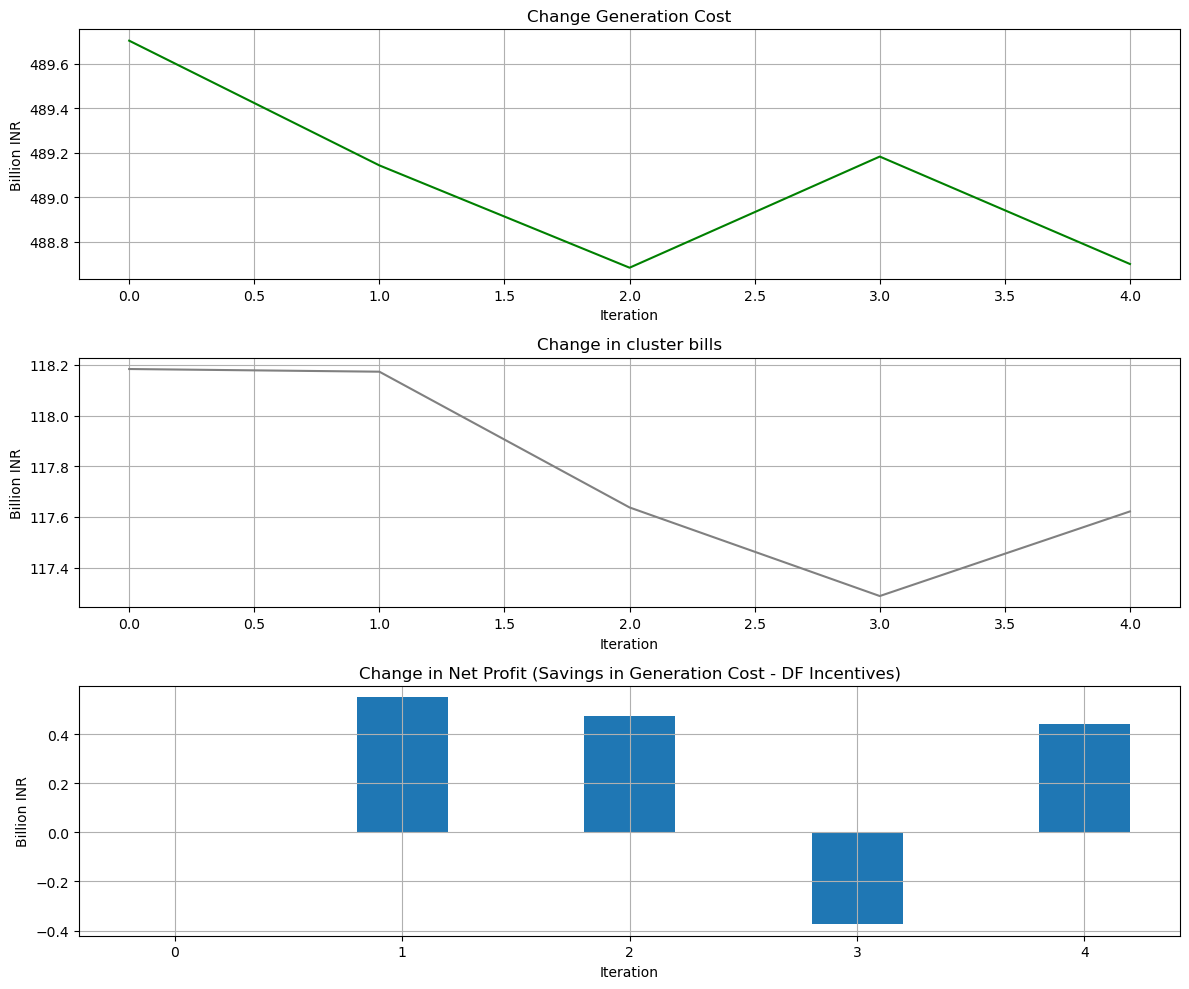

In [110]:
total_cluster_bills = np.zeros(number_of_iterations)
total_gen_cost = np.zeros(number_of_iterations)
change_in_bills = np.zeros(number_of_iterations)
change_in_gen_cost =np.zeros(number_of_iterations)
change_in_net_profit = np.zeros(number_of_iterations)



for i in range(number_of_iterations):
    total_cluster_bills[i] = iterative_cluster_bills[i].sum().sum()
    total_gen_cost[i] = iterative_total_gen_cost[i]
    change_in_bills[i] = total_cluster_bills[i] - total_cluster_bills[0]
    change_in_gen_cost[i] =total_gen_cost[0] - total_gen_cost[i]
    change_in_net_profit[i] = change_in_gen_cost[i] + change_in_bills[i]



fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(12, 10))

ax1.plot(total_gen_cost/1000000000, color='green')
ax1.set_title('Change Generation Cost')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Billion INR')
ax1.grid(True)

ax2.plot(total_cluster_bills/1000000000, color='grey')
ax2.set_title('Change in cluster bills')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Billion INR')
ax2.grid(True)

ax3.bar(range(number_of_iterations), change_in_net_profit/1000000000, width =0.4)
ax3.set_title('Change in Net Profit (Savings in Generation Cost - DF Incentives)')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Billion INR')
ax3.grid(True)


plt.tight_layout()


plt.show()



In [111]:
print((total_cluster_bills[0] - total_cluster_bills[2])/10000000000)
print((iterative_total_gen_cost[0] - iterative_total_gen_cost[2] -(total_cluster_bills[0] - total_cluster_bills[2]))/1000000000)

0.054624926071748355
0.47433020829039


In [112]:
## Load shift in different categories of load

@interact(iteration=widgets.Dropdown(options=range(number_of_iterations), description='Iteration:'))
def update_plot(iteration):
    
    fig = sp.make_subplots(rows=3, cols=1,shared_xaxes=True,subplot_titles = ('Base and optimal demand','RE generation forecast','Base and optimal net demand'))
    x_values = np.linspace(1, 8760, 8760)
    x1 = x_values        
        
    demand_base = iterative_demand[0]
    demand = iterative_demand[iteration]
    net_demand_base = iterative_demand[0] - re.sum(axis=1)
    net_demand = iterative_demand[iteration] -re.sum(axis=1)
    solar_gen = re['Solar']
    wind_gen = re['Wind']
    
    
    # Plot the data
    fig.add_trace(go.Scatter(x=x1, y=demand_base, mode='lines', name=f'Base demand'), row=1, col=1)
    fig.add_trace(go.Scatter(x=x1, y=demand, mode='lines', name=f'Demand - iteration: {iteration}'), row=1, col=1)
          
    fig.add_trace(go.Scatter(x=x1, y=solar_gen, mode='lines', name=f'Solar generation'), row=2, col=1)
    fig.add_trace(go.Scatter(x=x1, y=wind_gen, mode='lines', name=f'Wind generation'), row=2, col=1)
    
   
    fig.add_trace(go.Scatter(x=x1, y=net_demand_base, mode='lines', name=f'Base net demand'), row=3, col=1)
    fig.add_trace(go.Scatter(x=x1, y=net_demand, mode='lines', name=f'net demand -iteration: {iteration}'), row=3, col=1)
   

    fig.update_layout(
        height=900,
        width=900,
        margin=dict(l=3, r=2, b=0, t=100),
        boxgroupgap=0.00,
       
        
     )

    # Add axis titles for each subplot
    fig.update_xaxes(title_text="Time (hours)", row=1, col=1)
    fig.update_yaxes(range=[min(demand_base),max(demand_base)],title_text="Demand (MW)", row=1, col=1)
    
    fig.update_xaxes(title_text="Time (hours)", row=2, col=1)
    fig.update_yaxes(title_text="Generation (MW)", row=2, col=1)
    
    fig.update_xaxes(title_text="Time (hours)", row=3, col=1)
    fig.update_yaxes(range=[min(net_demand_base),max(net_demand_base)],title_text="Net Demand (MW)", row=3, col=1)
    

    fig.show()

interactive(children=(Dropdown(description='Iteration:', options=(0, 1, 2, 3, 4), value=0), Output()), _dom_cl…

In [113]:
@interact(iteration=widgets.Dropdown(options=range(number_of_iterations), description='Iteration:'))
def update_plot2(iteration):
    x_values = np.linspace(1, 8760, 8760)
    x1 = x_values 
    fig = sp.make_subplots(rows=3, cols=1,shared_xaxes=True,subplot_titles = ('Tariff signal','Per Unit Generation cost','Flexibility offered by consumers'))

    fig.add_trace(go.Scatter(x=x1, y=iterative_tariff_signals[0].iloc[:,0], mode='lines',  line=dict(shape='hv'), name=f'Base tariff signal'), row=1, col=1)
    fig.add_trace(go.Scatter(x=x1, y=iterative_tariff_signals[iteration].iloc[:,2], mode='lines', line=dict(shape='hv'), name=f'Tariff signal - iteration: {iteration}'), row=1, col=1)
          
    fig.add_trace(go.Scatter(x=x1, y=iterative_pu_gen_cost[0], mode='lines', name=f'Pu gen cost base'), row=2, col=1)
    fig.add_trace(go.Scatter(x=x1, y=iterative_pu_gen_cost[iteration], mode='lines', name=f'Pu gen cost iteration: {iteration}'), row=2, col=1)
    
    fig.add_trace(go.Scatter(x=x1, y=-iterative_opt_load[0].iloc[:,:].sum(axis=1)+iterative_opt_load[iteration].iloc[:,:].sum(axis=1), mode='lines', name=f'Flexibility offered in iteration {iteration}'), row=3, col=1)
    
    fig.update_layout(
        height=900,
        width=900,
        margin=dict(l=3, r=2, b=0, t=100),
        boxgroupgap=0.00,
       
        
     )

    # Add axis titles for each subplot
    fig.update_xaxes(title_text="Time (hours)", row=1, col=1)
    fig.update_yaxes(title_text="INR/kWh", row=1, col=1)
    
    fig.update_xaxes(title_text="Time (hours)", row=2, col=1)
    fig.update_yaxes(title_text="INR/kWh", row=2, col=1)
    
    fig.update_xaxes(title_text="Time (hours)", row=3, col=1)
    fig.update_yaxes(title_text="MW", row=3, col=1)
    
    fig.show()

interactive(children=(Dropdown(description='Iteration:', options=(0, 1, 2, 3, 4), value=0), Output()), _dom_cl…

In [104]:
@interact(clusters=widgets.Dropdown(options=iterative_opt_load[0].columns, description='cluster:'))


def update_plot3(clusters):
    x_values = np.linspace(1, 8760, 8760)
    x1 = x_values 
    fig = sp.make_subplots(rows=1, cols=1,shared_xaxes=True,subplot_titles = 'Base load and optimal load')
    
    
    
    for i in range(number_of_iterations):
        selected_df = iterative_opt_load[i]
      
        fig.add_trace(go.Scatter(x=x1, y=selected_df.loc[:,clusters], mode='lines', name=f'Cluster load: iteration {i}'), row=1, col=1)
    
          
    
    fig.update_layout(
        height=500,
        width=900,
        margin=dict(l=3, r=2, b=0, t=100),
        boxgroupgap=0.00,   
        
     )

    # Add axis titles for each subplot
    fig.update_xaxes(title_text="Time (hours)", row=1, col=1)
    fig.update_yaxes(title_text="MW", row=1, col=1)
    

    
    fig.show()

interactive(children=(Dropdown(description='cluster:', options=('hos_Cluster-1', 'hos_Cluster-2', 'hos_Cluster…